# Data Pretreatment

## Load Data

In [3]:
## Libraries
# lightkurve
#import lightkurve as lk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import STL
#import statsmodels.api as sm
# import itertools
import warnings
## Pyramid ARIMA
from pmdarima import auto_arima
# import pmdarima
import pickle

In [4]:
## Data
df = pd.read_csv("../0.Data/031381302.csv", index_col = "time")

# Check
print(df.shape)

## Time Series of interest
lightcurve = df.loc[:, ["pdcsap_flux"]]
lightcurve.sort_index(inplace=True)

# Check
print(lightcurve.shape); lightcurve.info(); lightcurve.head()

(17719, 23)
(17719, 1)
<class 'pandas.core.frame.DataFrame'>
Float64Index: 17719 entries, 1437.978645522663 to 1464.2854684532865
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   pdcsap_flux  17033 non-null  float64
dtypes: float64(1)
memory usage: 276.9 KB


,pdcsap_flux
time,
1437.978646,NaN
1437.980034,NaN
1437.981423,NaN
1437.982812,NaN
1437.984201,NaN


## Reindexing

Adjusting the indices to focus the time series.
1. Adding indices where observations are missing, with the intention to impute them so to create a more stable time series.
2. Removing edge null values, which are unnecessary and hard to impute.

In [5]:
def fill_times(series):
    ## Time Differences
    time_diffs = series.index.to_series().diff()

    ## Setup
    series_fill = series.copy()
    med = time_diffs.median()

    ## Iteration
    for k, id in enumerate(series.index):
        if k == 0: continue
        # print(k, id)
        diff = time_diffs.iloc[k] #id - pdcsap["time"][k - 1]
        diff_size = diff / med
        if diff_size < 2:
            pass
        elif (diff_size >= 2) & (diff_size < 3):
            new_rows = pd.DataFrame({series.columns[0]: np.nan}, index = [id - med])
            series_fill = pd.concat([series_fill, new_rows])
        else:
            new_inds = np.arange(start = series.index[k - 1] + med, stop = id - med, step = med)
            new_rows = pd.DataFrame({series.columns[0]: np.nan}, index = new_inds)
            series_fill = pd.concat([series_fill, new_rows])

    ## Cleanup
    series_fill.sort_index(inplace = True)

    return series_fill

(18856, 1)
<class 'pandas.core.frame.DataFrame'>
Float64Index: 18856 entries, 1437.978645522663 to 1464.2854684532865
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   pdcsap_flux  17033 non-null  float64
dtypes: float64(1)
memory usage: 294.6 KB
None
<class 'pandas.core.frame.DataFrame'>
Float64Index: 18229 entries, 1438.198088310551 to 1463.6229730857283
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   pdcsap_flux  17033 non-null  float64
dtypes: float64(1)
memory usage: 284.8 KB
None
Float64Index([1438.9564169769565, 1441.0230735546481,  1441.024462437205,
               1441.025851319762,  1441.027240202319],
             dtype='float64')
(1196,)


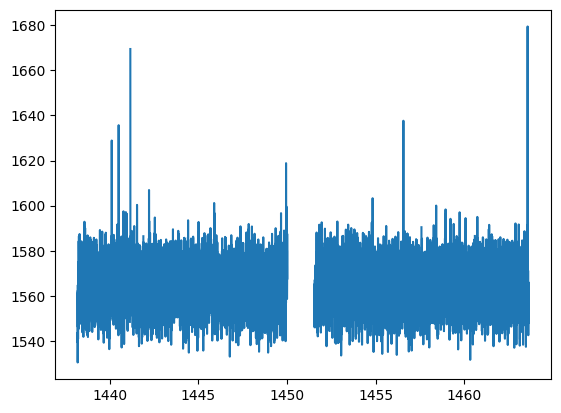

In [6]:
## Fill indices
lc_fill = fill_times(lightcurve)
print(lc_fill.shape)
print(lc_fill.info())

## Remove edge null indices
min_ind = lc_fill.dropna().index.min()
max_ind = lc_fill.dropna().index.max()
lc_fill = lc_fill.loc[min_ind:max_ind]
print(lc_fill.info())

## Identify null_indices
null_indices = lc_fill.iloc[np.where(lc_fill.isna())[0]].index
print(null_indices[0:5])
print(null_indices.shape)

## Check
plt.plot(lc_fill)

## ARIMA Imputation

Imputing missing values by initially interpolating with cubic splines, then running an ARIMA model with Fourier Series terms to handle seasonality to improve the imputations.

### Cubic Spline Interpolation

In [7]:
lc_interp = lc_fill.interpolate(method='pchip')
## Notes:
# 'krogh' doesn't work
# 'akima' interesting
# 'pchip' very interesting - 1-D monotonic cubic spline interpolation.
#   - https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.pchip_interpolate.html
#   - https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.PchipInterpolator.html#scipy.interpolate.PchipInterpolator
print(lc_interp.info())

<class 'pandas.core.frame.DataFrame'>
Float64Index: 18229 entries, 1438.198088310551 to 1463.6229730857283
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   pdcsap_flux  18229 non-null  float64
dtypes: float64(1)
memory usage: 284.8 KB
None


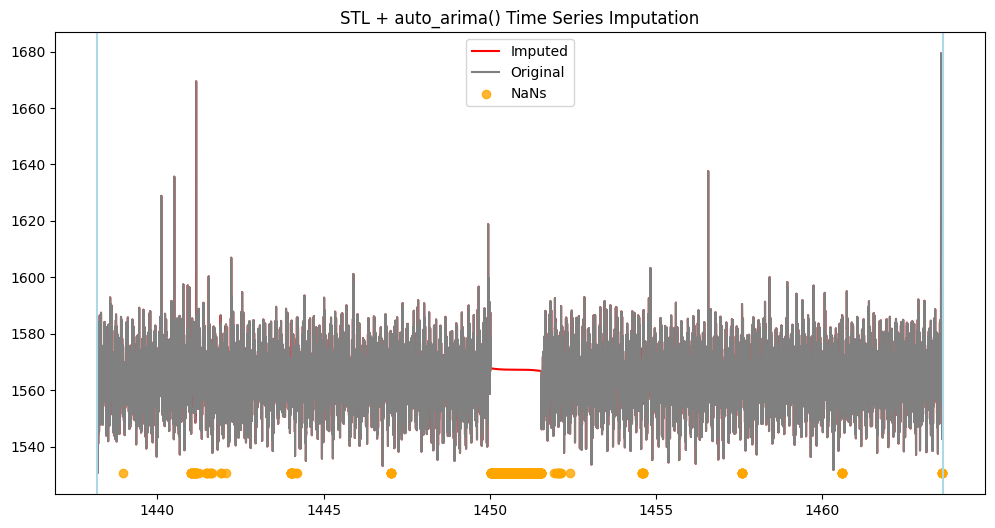

In [8]:
## Check
# Plot original vs imputed series
plt.figure(figsize=(12,6))
plt.plot(lc_interp, label='Imputed', color = "red")
plt.plot(lc_fill, label='Original', color = "grey")
plt.scatter(null_indices, np.full(len(null_indices), lc_fill.min()), label='NaNs', color='orange', alpha=0.8)
plt.axvline(lc_fill.index.max(), color = "lightblue")
plt.axvline(lc_fill.index.min(), color = "lightblue")
plt.title("STL + auto_arima() Time Series Imputation")
# plt.xlim((1449.5, 1452))
plt.legend()
plt.show()

### ARIMA Imputation

In [9]:
## ARIMA with Fourier terms ##
## Fourier terms
from pmdarima.preprocessing import FourierFeaturizer

four_order = 1
fourier_terms = FourierFeaturizer(240, four_order)
y_prime, exog = fourier_terms.fit_transform(lc_interp)
exog['time'] = y_prime.index # is exactly the same as manual calculation in the above cells
exog = exog.set_index(exog['time'])
exog = exog.drop(columns=['time'])
print(y_prime.head()); print(exog.head())
print((y_prime.shape, exog.shape))

             pdcsap_flux
1438.198088    1561.9932
1438.199477    1530.5082
1438.200866    1534.7330
1438.202255    1558.9431
1438.203644    1553.7203
             FOURIER_S240-0  FOURIER_C240-0
time                                       
1438.198088        0.026177        0.999657
1438.199477        0.052336        0.998630
1438.200866        0.078459        0.996917
1438.202255        0.104528        0.994522
1438.203644        0.130526        0.991445
((18229, 1), (18229, 2))


In [10]:
## auto_arima
## Suppress warnings for clean output
warnings.filterwarnings("ignore")

## Auto ARIMA
model_auto = auto_arima(
    y_prime,
    X=exog,
    start_p = 12, start_q = 0,
    max_p = 20, max_q = 20,
    trace=True,
    error_action='ignore'
)

print("Selected model order:", model_auto.order, "Seasonal order:", model_auto.seasonal_order)

Performing stepwise search to minimize aic
 ARIMA(12,0,0)(0,0,0)[0] intercept   : AIC=126649.529, Time=16.11 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=132098.110, Time=1.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=129732.563, Time=3.20 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=130400.442, Time=3.11 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=480514.432, Time=0.26 sec
 ARIMA(11,0,0)(0,0,0)[0] intercept   : AIC=126655.497, Time=6.89 sec
 ARIMA(13,0,0)(0,0,0)[0] intercept   : AIC=126649.708, Time=8.66 sec
 ARIMA(12,0,1)(0,0,0)[0] intercept   : AIC=126653.715, Time=17.13 sec
 ARIMA(11,0,1)(0,0,0)[0] intercept   : AIC=126659.942, Time=7.36 sec
 ARIMA(13,0,1)(0,0,0)[0] intercept   : AIC=126652.014, Time=19.71 sec
 ARIMA(12,0,0)(0,0,0)[0]             : AIC=inf, Time=17.81 sec

Best model:  ARIMA(12,0,0)(0,0,0)[0] intercept
Total fit time: 101.303 seconds
Selected model order: (12, 0, 0) Seasonal order: (0, 0, 0, 0)


In [11]:
# print(model_auto.fit_with_exog_)
print(model_auto.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                18229
Model:              SARIMAX(12, 0, 0)   Log Likelihood              -63308.764
Date:                Tue, 04 Mar 2025   AIC                         126649.529
Time:                        10:03:34   BIC                         126774.501
Sample:                             0   HQIC                        126690.600
                              - 18229                                         
Covariance Type:                  opg                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
intercept        287.4532     15.485     18.563      0.000     257.103     317.803
FOURIER_S240-0     0.0678      0.382      0.178      0.859      -0.680       0.816
FOURIER_C240-0    -1.7077      0.386

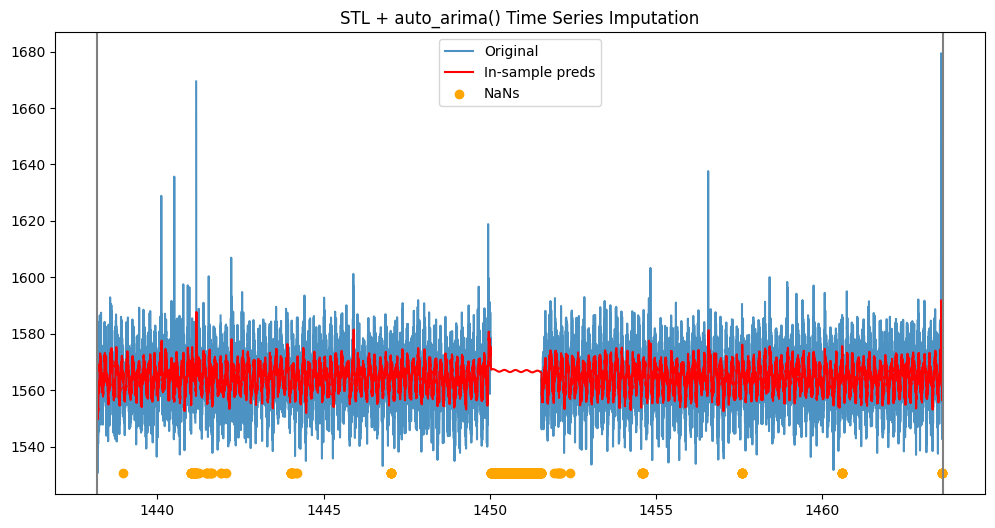

In [ ]:
## Check
# Plot original vs imputed series
plt.figure(figsize=(12,6))
plt.plot(lc_fill, label='Original', alpha=0.8)
plt.plot(lc_fill.index, model_auto.predict_in_sample(exog), label='In-sample preds', color='red')
plt.scatter(null_indices, np.full(len(null_indices), lc_fill.min()), label='NaNs', color='orange')
plt.axvline(lc_fill.index.max(), color = "grey")
plt.axvline(lc_fill.index.min(), color = "grey")
plt.title("STL + auto_arima() Time Series Imputation")
plt.legend()
# plt.xlim((1440, 1441))
plt.show()

In [13]:
## IMPUTE ##
model = model_auto

d = model.order[1]
pred_vals = model.predict_in_sample(exog)
lc_fill.loc[null_indices[np.isin(null_indices, lc_fill.index[d:])], "pdcsap_flux"] = pred_vals[np.isin(lc_fill.index[d:], null_indices)] 

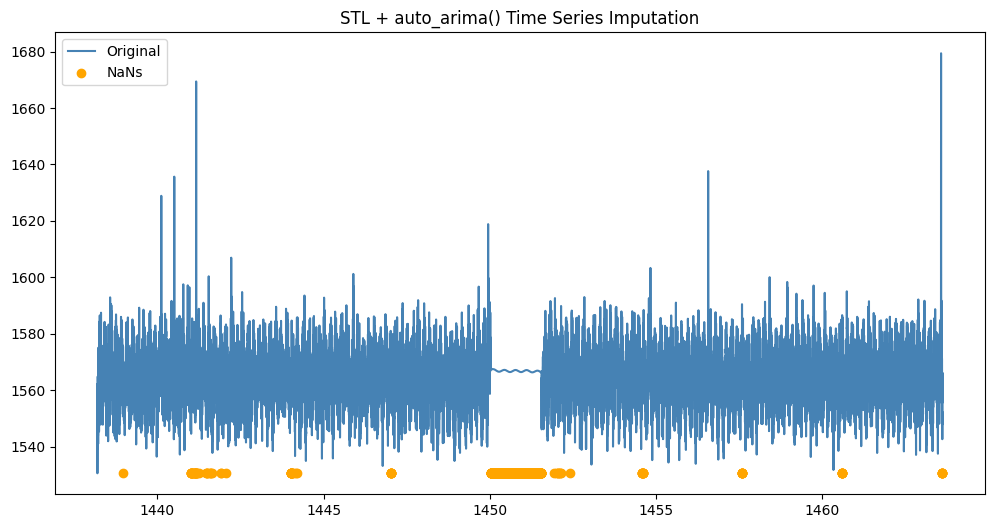

In [16]:
## Check
# Plot original vs imputed series
plt.figure(figsize=(12,6))
plt.plot(lc_fill, label='Original', color='steelblue')
plt.scatter(null_indices, np.full(len(null_indices), lc_fill.min()), label='NaNs', color='orange')
plt.title("STL + auto_arima() Time Series Imputation")
plt.legend()
# plt.xlim((1440, 1441))
plt.show()

## STL Decomposition

Breaking down the imputed time series into Seasonal + Trend + Irregular (Noise) components. This is in order to de-trend and de-seasonalize the data, meaning we are looking to extract the Noise component as the time series of interest for our flare identification model.

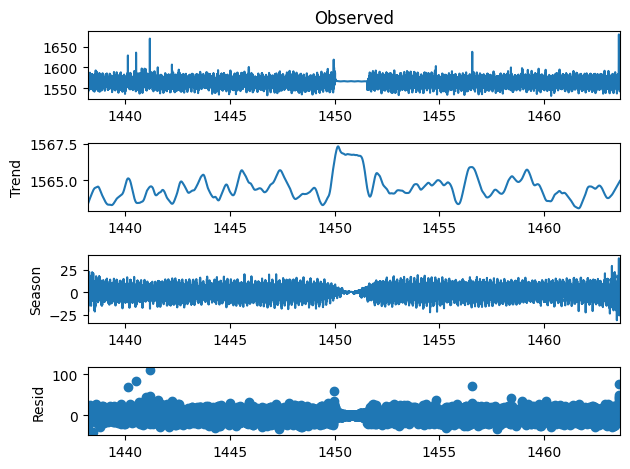

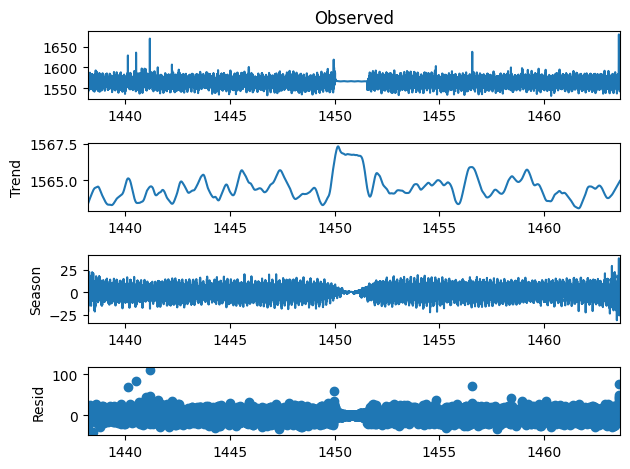

In [17]:
## STL Decomposition
stl = STL(lc_fill, period=240, robust=True)  # Use period=240 based on EDA
decomposition = stl.fit()

# Extract components
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

## Plot
decomposition.plot()

In [18]:
## Check
residual.info(); residual.head(); residual.describe()

<class 'pandas.core.series.Series'>
Float64Index: 18229 entries, 1438.198088310551 to 1463.6229730857283
Series name: resid
Non-Null Count  Dtype  
--------------  -----  
18229 non-null  float64
dtypes: float64(1)
memory usage: 800.9 KB


count    18229.000000
mean         0.084108
std          6.711376
min        -41.444380
25%         -3.106505
50%         -0.012013
75%          3.185056
max        109.397990
Name: resid, dtype: float64

In [19]:
## Save the imputed dataset
lc_fill["pdcsap_clean"] = residual #pdcsap_imputed
lc_fill["trend"] = trend
lc_fill["seasonal"] = seasonal
lc_fill.to_csv("../0.Data/031381302_imputed.csv")

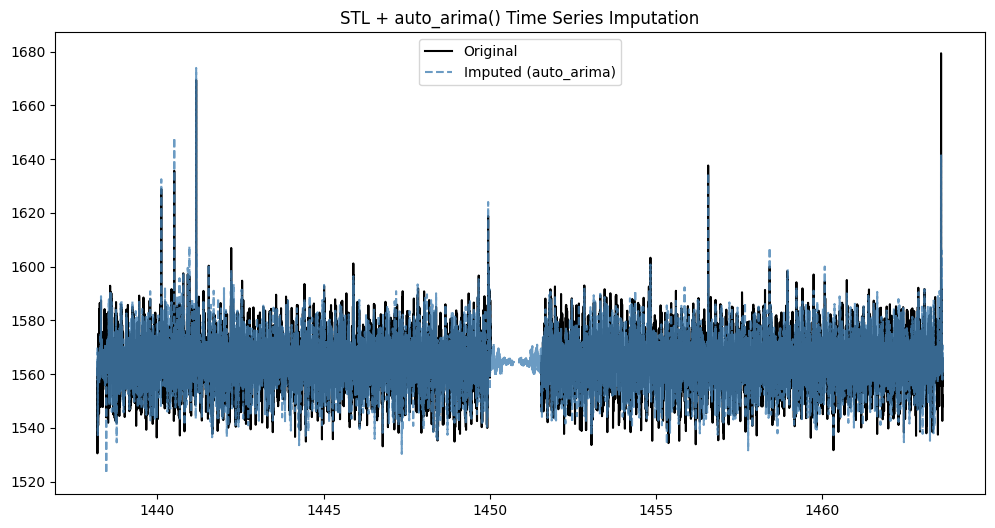

In [21]:
## Check
# Plot original vs imputed series
plt.figure(figsize=(12,6))
plt.plot(lightcurve, label='Original', color = "black")
plt.plot(lc_fill["pdcsap_clean"] + trend.mean(), label='Imputed (auto_arima)', linestyle='--', color = "steelblue", alpha = 0.8)
plt.title("STL + auto_arima() Time Series Imputation")
plt.legend()
plt.show()

# # Plot imputed series
# plt.figure(figsize=(12,6))
# plt.plot(lc_fill["pdcsap_clean"], label='Imputed (auto_arima)', color = "steelblue")
# plt.title("STL + auto_arima() Time Series Imputation")
# plt.legend()
# plt.show()